[RQ4] What is the most common way of payments? Discover the way payments are executed in each borough and visualize the number of payments for any possible means. Then run the Chi-squared test to see whether the method of payment is correlated to the borough. Then, comment the results.



In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
import seaborn as sns 

%matplotlib inline

import matplotlib.pyplot as plt

import functions

import datetime

In [2]:
# directory path for csv files (dataset from Jan to Jun 2018)
df_names=['data/yellow_tripdata_2018-01.csv','data/yellow_tripdata_2018-02.csv',
          'data/yellow_tripdata_2018-03.csv','data/yellow_tripdata_2018-04.csv',
         'data/yellow_tripdata_2018-05.csv','data/yellow_tripdata_2018-06.csv']

# taxi_zone_lookup.csv file
taxi_zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')

# The way payments are executed in each borough 

In [3]:
def payments_per_borough():
    # making a list of Borough
    borough_lst = list(np.unique(taxi_zone_lookup.Borough))
    res=[]

    for i,df_name in enumerate(df_names):
            # load the ith dataframe, taking only the t_pickup_datetime column
            df = pd.read_csv(df_name,usecols= ['payment_type','PULocationID'],nrows=100)

            df=pd.merge(df,taxi_zone_lookup,how='left',left_on='PULocationID',right_on='LocationID')

            res.append(df.groupby(['Borough','payment_type']).count().iloc[:,0]) 
    res=pd.DataFrame(pd.concat(res,axis=1).sum(axis=1))
    res.reset_index(inplace=True)
    return res

In [4]:
res=payments_per_borough()

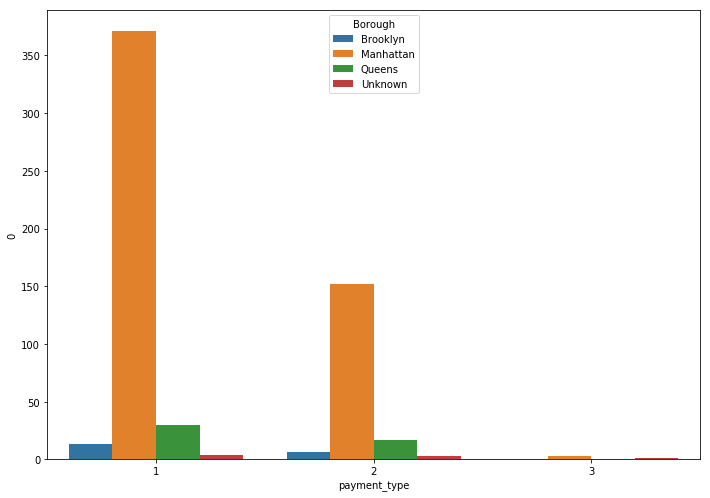

In [5]:
fig, ax = plt.subplots()
    # the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.barplot(y=0, x='payment_type',data=res,hue='Borough')

# The number of payments for any possible means

In [6]:
def all_payments(df_names):
    payment_type_dict = defaultdict(list)
    payment_type=['Credit card','Cash','No charge','Dispute','Unknown','Voided trip']
    payment_type_lst=[]

    for i in range(1,7):
        payment_type_dict[i]=0 #values for each payment_type should be 0 at the beginning
    for i,df_name in enumerate(df_names):
            # load the ith dataframe, taking only the t_pickup_datetime column
            df = pd.read_csv(df_name,usecols= ['payment_type','tpep_pickup_datetime'],parse_dates=['tpep_pickup_datetime'])

            #I think we should consider making a clean method? hmm
            # cleaning the attribute: removing years different from 2018 and months different from ith month
            df=df[(df['tpep_pickup_datetime'].dt.year == 2018) & (df['tpep_pickup_datetime'].dt.month == i+1)]

            x=df.groupby(['payment_type']).count().iloc[:,0]
            for ind,val in enumerate(x):
                payment_type_dict[ind+1]+=val
    for item in payment_type_dict.values():
        payment_type_lst.append(item)
    return payment_type_lst,payment_type

In [7]:
payment_type_lst,payment_type=all_payments(df_names)

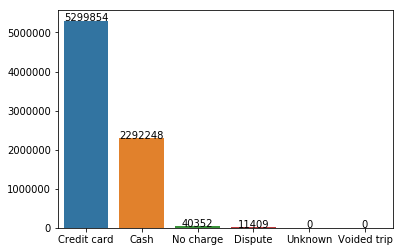

In [8]:
ax = sns.barplot(y=payment_type_lst, x=payment_type)
for ind,val in enumerate(payment_type_lst):
    ax.text(ind,val,val, color='black', ha="center")

plt.show()

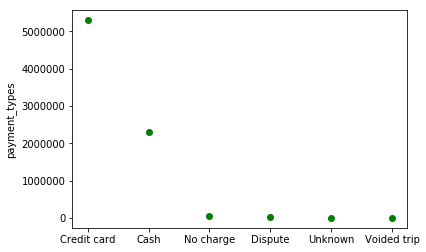

In [9]:
plt.xticks(range(1,7),payment_type)
plt.ylabel("payment_types")
plt.plot(range(1,7), payment_type_lst, 'go')